In [42]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

from IPython.display import display, Markdown, HTML

def markdown(s):
    return display(Markdown(s))

display(HTML("""
<style>
.custom-assignment-text {
    background-color: lightyellow;
    border: 1px solid darkkhaki; 
    padding: 10px;
    border-radius: 2px
}
</style>"""))

markdown("Surround markdown cells with  `<div class=\"custom-assignment-text\">\\n\\n ... \\n\\n</div>` to mark professor-provided assignment content")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


Surround markdown cells with  `<div class="custom-assignment-text">\n\n ... \n\n</div>` to mark professor-provided assignment content

<div class="custom-assignment-text">

# Part 1: Similarity Metrics

</div>

In [2]:
from cs168.mini_project_2 import load_data
from itertools import combinations
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.testing import assert_approx_equal, assert_allclose
import pandas as pd
from scipy.spatial.distance import pdist, squareform

pd.set_option("precision", 7)

from bokeh.io import output_file, show, output_notebook, output_file, reset_output
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource, LinearColorMapper, PrintfTickFormatter, HoverTool, Title)
from bokeh.plotting import figure
from bokeh.transform import transform
from bokeh.palettes import Blues8

<div class="custom-assignment-text">

## Goal 

The goal of this part of the assignment is to understand better the differences between distance
metrics, and to think about which metric makes the most sense for a particular application.

</div>

<div class="custom-assignment-text">

## Description

In this part you will look at the similarity between the posts on various newsgroups. We’ll use the well-known [20 newsgroups dataset](http://qwone.com/~jason/20Newsgroups/). You will use a version of the dataset where every article is represented by a bag-of-words — a vector indexed by words, with each component indicating the number of occurrences of that word. You will need 3 files: `data50.csv`, `label.csv`, and `group.csv`, all of these can be downloaded from the course website. In `data50.csv` there is a sparse representation of the bags-of-words, with each line containing 3 fields: `articleId`, `wordId`, and `count`. To find out which group an article belongs to, use the file `label.csv`, where for `articleId` $i$, line $i$ in `label.csv` contains the `groupId`. Finally the group name is in `group.csv`, with line $i$ containing the name of group $i$.

We’ll use the following similarity metrics, where $x$ and $y$ are two bags of words:

* Jaccard Similarity: $J(x,y) = \frac{\sum_i{min(x_i,y_i)}}{\sum_i{max(x_i,y_i)}}$
* $L_2$ Similarity: $L_2(x,y) = \|x - y\|_2 = -\sqrt{\sum_i(x_i - y_i)^2}$
* Cosine Similarity: $S_C(x, y) = \frac{\sum_i{x_i \cdot y_i}}{\|x\|_2 \cdot \|y\|_2}$

Note that Jaccard and cosine similarity are numbers between 0 and 1, while $L_2$ similarity is between $-\infty$ and 0 (with higher numbers indicating more similarity).

</div>

<div class="custom-assignment-text">

(a) (2 points) Make sure you can import the given datasets into whatever language you’re using. For
example, if you’re using python, read the data50.csv file and store the information in an appropriate
way. Remember that the total number of words in the corpus is huge, so you might want to work with
a sparse representation of your data (e.g., you don’t want to waste space on words that don’t occur in
a document). If you’re using MATLAB, you can simply import the data using the GUI.

</div>

In [3]:
group_names, data, labels = load_data()

assert group_names.shape == (20,)
assert group_names.isnull().sum().sum() == 0
assert group_names.index[0] == 1

assert data.shape == (1000, 19575)
assert data.isnull().sum().sum() == 0
assert data.index[0] == 1

assert labels.shape == (1000,)
assert labels.isnull().sum().sum() == 0
assert labels.index[0] == 1

"OK"

'OK'

<div class="custom-assignment-text">

(b) (8 points) Implement the three similarity metrics described above. For each metric, prepare the following plot. The plot will look like a 20 × 20 matrix. Rows and columns are index by newsgroups (in the same order). For each entry $(A, B)$ of the matrix (including the diagonal), compute the average similarity over all ways of pairing up one article from $A$ with one article from $B$. After you’ve computed these 400 numbers, plot your results in a heatmap. Make sure that you label your axes with the group
names and pick an appropriate colormap to represent the data: the rainbow colormap may look fancy, but a simple color map from white to blue may be a lot more insightful. Make sure to include a legend. (Note that the computation might take five or ten minutes, but shouldn’t take much more.)

</div>

In [4]:
# Ultra-simple rows for testing the similarity metrics below
def get_test_rows():
    return (pd.DataFrame([4, 5, 6]), pd.DataFrame([5, 4, 6]), pd.DataFrame([1, 2, 6]), pd.DataFrame([0, 0, 0]))

In [5]:
def jaccard_sim(x, y):
    divisor = np.maximum(x,y).sum().item()
    if divisor == 0:
        return 1.0
    df = np.minimum(x, y).sum() / divisor
    return df.item()

def _test_jaccard_sim():
    (df_1, df_2, df_3, df_0) = get_test_rows()
    assert jaccard_sim(df_1, df_2) == 14/16 == .875
    assert jaccard_sim(df_1, df_3) == 9/15 == .6
    assert jaccard_sim(df_1, df_1) == 1
    assert jaccard_sim(df_0, df_0) == 1

_test_jaccard_sim()
"OK"

'OK'

In [6]:
def l2_norm(x):
    return math.sqrt((x**2).sum())

def l2_sim(x, y):
    return -l2_norm(x - y)

def _test_l2_sim():
    (df_1, df_2, df_3, df_0) = get_test_rows()
    assert_approx_equal(l2_sim(df_1, df_2), -1.4142136)
    assert_approx_equal(l2_sim(df_1, df_3), -4.2426407)
    assert_approx_equal(l2_sim(df_2, df_3), -4.472136)
    assert_approx_equal(l2_sim(df_1, df_1), 0)
    assert_approx_equal(l2_sim(df_0, df_0), 0)

_test_l2_sim()
"OK"

'OK'

In [7]:
def cosine_sim(x, y):
    divisor = (l2_norm(x) * l2_norm(y))
    if divisor == 0:
        return 1
    df = (x*y).sum() / divisor
    return df.item()

def _test_cosine_sim():
    (df_1, df_2, df_3, df_0) = get_test_rows()
    assert_approx_equal(cosine_sim(df_1, df_2), 0.987013)
    assert_approx_equal(cosine_sim(df_1, df_3), 0.8898826)
    assert_approx_equal(cosine_sim(df_1, df_1), 1)
    assert_approx_equal(cosine_sim(df_0, df_0), 1)

_test_cosine_sim()
"OK"

'OK'

Note that using the distance functions provided in `scipy.spatial.distance` would likely be more performant, but to fulfill the requirements of the assignment we've re-implemented them above.

In [8]:
def get_all_distances(df, metric):
    """Returns a square matrix where the (i, j)th element
    is the result of calculating metric(df[i],df[j])"""

    similarities = pd.DataFrame(
        squareform(pdist(df, metric)), index=df.index, columns=df.index
    )
    # Numpy skips the diagonal, but I want to include it
    for idx in df.index:
        if idx in df:
            element = df[idx]
            val = metric(element, element)
            if val == np.nan:
                print(f'{idx} was null')
            similarities[idx][idx] = metric(element, element)
        # else:
        #     print(f'skipping {idx}')
    return similarities

def _test_get_all_distances():
    test_data = pd.DataFrame([[4, 5, 6], [5, 4, 6], [1, 2, 6]])
    actual = get_all_distances(test_data, l2_sim)
    expected = [
            [0.0, -1.41421356, -4.24264069],
            [-1.41421356, 0.0, -4.47213595],
            [-4.24264069, -4.47213595, 0.0],
        ]
    assert_allclose(actual, expected)

_test_get_all_distances()
"OK"

'OK'

In [29]:
def get_average_distances(data, metric, labels):
    """Params:
    - data: dataframe containing rows to be compared against each other
    - metric: similarity metric for comparing rows
    - labels: labels for the rows in data
    Returns: a square symmetric matrix where elements (i, j) and (j, i) give the average
    similarity score among all pairs of data rows with label i and all with label j."""
    unique_labels = pd.unique(labels)
    all_distances = pd.DataFrame(get_all_distances(data, metric))
    all_label_average_distances = []

    for idx_1, label_1 in enumerate(unique_labels):
        label_1_distances = []
        for idx_2, label_2 in enumerate(unique_labels):
            # similarity is symmetric, so don't compute sim(j, i) if we've already computed sim(i, j)
            if idx_2 < idx_1:
                label_1_distances.append(all_label_average_distances[idx_2][idx_1])
                continue
            # get all distances between items of label_1 and label_2
            filtered = all_distances[labels == label_1].loc[:, labels == label_2]
            # then average these
            average_label_distance = filtered.mean().mean()
            label_1_distances.append(average_label_distance)
        all_label_average_distances.append(label_1_distances)
    
    df = pd.DataFrame(all_label_average_distances, columns=unique_labels, index=unique_labels).transpose()
    return df

def _test_get_average_distances():
    test_data = pd.DataFrame([[4, 5, 6], [5, 4, 6], [1, 2, 6]])
    test_labels = pd.Series([1,2,1])
    expected = [
        [-2.1213203, -2.9431748], 
        [-2.9431748, 0]
    ]
    actual = get_average_distances(test_data, l2_sim, test_labels)
    assert_allclose(actual, expected)

_test_get_average_distances()
"OK"

'OK'

In [30]:
%time jaccard_similarities = get_average_distances(data, jaccard_sim, labels)
jaccard_similarities = jaccard_similarities.rename(index=group_names, columns=group_names)

CPU times: user 59.2 s, sys: 639 ms, total: 59.9 s
Wall time: 1min 1s


In [31]:
%time l2_similarities = get_average_distances(data, l2_sim, labels)
l2_similarities = l2_similarities.rename(index=group_names, columns=group_names)

CPU times: user 26 s, sys: 409 ms, total: 26.4 s
Wall time: 26.6 s


In [32]:
%time cosine_similarities = get_average_distances(data, cosine_sim, labels)
cosine_similarities = cosine_similarities.rename(index=group_names, columns=group_names)

CPU times: user 46.9 s, sys: 757 ms, total: 47.7 s
Wall time: 48.4 s


In [33]:
# Adapted from code provided by course
def matplotlib_heat_map(df, title):
    fig, ax = plt.subplots()
    # create the map w/ color bar legend
    heatmap = ax.pcolor(df, cmap=plt.cm.Blues)
    cbar = plt.colorbar(heatmap)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(df.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(df.shape[1])+0.5, minor=False)

    # diagonal matrix from top-left to bottom right
    ax.invert_yaxis()

    ax.set_xticklabels(df.index)
    ax.set_yticklabels(df.index)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    # make text smaller so it doesn't overlap
    ax.tick_params(axis='x', which='major', labelsize=8)

    ax.set_title(title)

    plt.tight_layout()
    fig.savefig(f'{title}.svg')


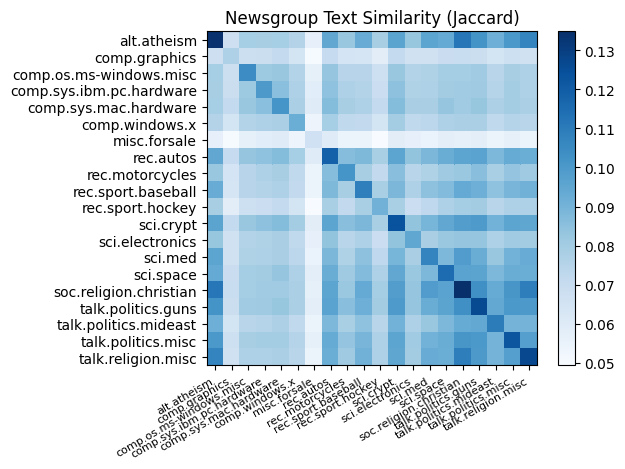

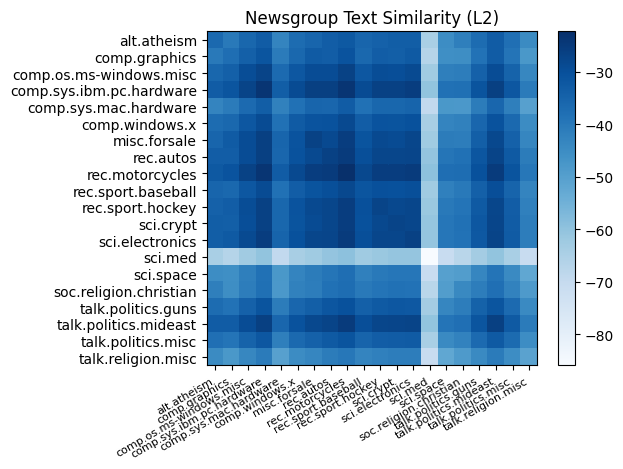

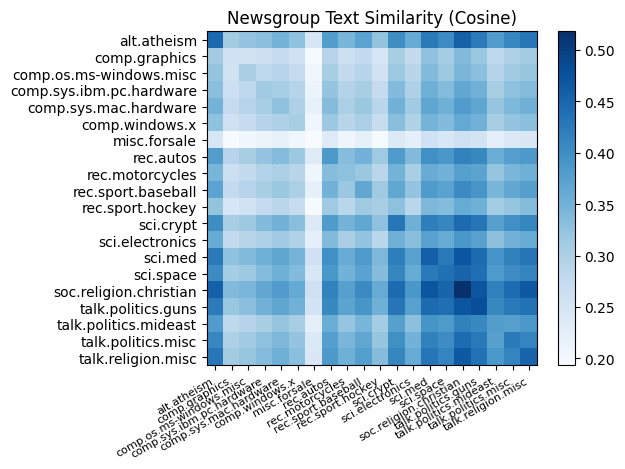

In [34]:
matplotlib_heat_map(jaccard_similarities, "Newsgroup Text Similarity (Jaccard)")
matplotlib_heat_map(l2_similarities, "Newsgroup Text Similarity (L2)")
matplotlib_heat_map(cosine_similarities, "Newsgroup Text Similarity (Cosine)")

While I appreciate the example code provided for the course, I find the above plots very difficult to inspect; I have to trace my fingers along the rows of squares to figure out which squares are comparing which categories. The text is also grainy, though that could probably be fixed by increasing the resolution of the image.

To make the results easier to examine, I put together the version below using Bokeh instead. When the cursor is hovered over an entry in the heat map, a tooltip displays the two categories being compared, along with their similarity score.

In [35]:
def bokeh_heat_map(input_df, title, file_name=None):
    """Parameters:
    - input_db: a 2D DataFrame containing category similarity data
    - title: the title of the plot, and optionally of the generated HTML
    - file_name: if provided, HTML will be written to this file and then 
        opened in the browser automatically; if not provided, the plot will
        be shown inline in the notebook."""
    
    if len(input_df.shape) != 2:
        raise ValueError(f"Expected a 2D DataFrame; shape of input_df was {input_df.shape}")
    
    # Bokeh requires a stack; x and y cateogory dimensions become columns "level_0" and "level_1"
    df = pd.DataFrame(input_df.stack(), columns=["similarity"]).reset_index()
    source = ColumnDataSource(df)

    # Show category names and the similarity score under the cursor
    hover = HoverTool(
        tooltips=[("", "@level_1"), ("", "@level_0"), ("", "@similarity")]
    )
    
    # set up figure
    fig = figure(
        title=Title(text=title, text_font_size="18pt"),
        x_range=list(input_df.index),
        y_range=list(reversed(input_df.columns)),
        toolbar_location=None, 
        tools=[hover], 
        x_axis_location="below")
    
    reset_output()
    if file_name:
        output_file(file_name, title=title)
        fig.sizing_mode = 'stretch_both'
    else:
        output_notebook(hide_banner=True)
        # using stretch dimensions in a notebook results in a tiny, unreadable figure
        fig.height = 600
        fig.width = 800
        
    # remove lines and ticks
    fig.xgrid.grid_line_color = None
    fig.ygrid.grid_line_color = None
    fig.axis.axis_line_color = None
    fig.axis.major_tick_line_color = None
    fig.axis.major_label_text_font_size = "10pt"
    fig.axis.major_label_standoff = 0
    # slanted to the left
    fig.xaxis.major_label_orientation = 1.0

    # Draw rectangles for the heat map
    # values increase from light to dark blue
    colors = list(reversed(Blues8))
    mapper = LinearColorMapper(palette=colors, low=df.similarity.min(), high=df.similarity.max())
    fig.rect(x="level_0", y="level_1", width=1, height=1, source=source,
           line_color=None, fill_color=transform('similarity', mapper))

    # Add a color key on the right side
    color_bar = ColorBar(color_mapper=mapper,
                         ticker=BasicTicker(desired_num_ticks=len(colors)),
                         formatter=PrintfTickFormatter(format="%.3f"))
    fig.add_layout(color_bar, 'right')

    show(fig)

In [36]:
# transpose so we get lower triangular matrix, which is easier to read
bokeh_heat_map(jaccard_similarities.transpose(), "Newsgroup Text Similarity (Jaccard)")
bokeh_heat_map(l2_similarities.transpose(), "Newsgroup Text Similarity (L2)")
bokeh_heat_map(cosine_similarities.transpose(), "Newsgroup Text Similarity (Cosine)")

<div class="alert alert-block alert-info">

(c) (4 points) Based on your three heatmaps, which of the similarity metrics seems the most reasonable, and why would you expect that/those metrics to be better suited to this data?

Are there any pairs of newsgroups that are very similar?

Would you have expected these to be similar?

</div>

Observations:

1. I would expect the diagonal to be darkest section of the plot for all of the plots, but the pattern is completely missing in the L2 plot and is pretty faint in the Cosine plot. The pattern is very clear in the Jaccard plot, though.
2. The `forsale` topic in the Jaccard and Cosine plots, and the `med` topic in the L2 plot have clearly visible white strips; I suppose this could be caused by a topic having quite a wide range of subtopics (medicine could be skin care or lung cancer or jogging, while forsale could be related to a wide variety of items from computers to dirt. It's surprising to me, though, that the similarity metrics disagree on which topics have this attribute. Once again, I think I trust the Jaccard metric the most, as it's the only one where a topic is clearly very different from all other topics while still being somewhat similar to itself.
3. The Cosine plot has a small cluster of related topics: Christianity, religion, atheism, guns, and maybe space. The L2 plot has a huge chunk of topics with high similarity, and while some of the topics actually are related, I think the cluster is much bigger than it should be. It's more useful to have smaller groups of related topics, as it indicates that the the score is correctly finding similar topics but has enough variation that a huge number of topics are not considered similar (which would reduce the similarity score's usefulness).

Given the above points, I would grade the similarity metrics generally in the order cosine > Jaccard > L2. If the particular application were the identification of duplicate or largely copied documents (i.e. plagiarism), then I believe that the Jaccard metric would work best.

Future work: I believe we could better compare these metrics if we re-sorted the topics to make the clusters more obvious (re-order to get bigger visible squares).

<div class="custom-assignment-text">

## Parts 2 and 3: A nearest-neighbor classification system
    
</div>

<div class="custom-assignment-text">

A “nearest-neighbor” classification system is conceptually extremely simple, and often is very effective. Given a large dataset of labeled examples, a nearest-neighbor classification system will predict a label for a new example, $x$, as follows: it will find the element of the labeled dataset that is closest to $x$—closest in whatever metric makes the most sense for that dataset—and then output the label of this closest point. \[As you can imagine, there are many natural extensions of this system—for example considering the labels of the $r > 1$ closest neighbors.]

From a computational standpoint, naively, finding the closest point to $x$ might be time consuming if the
labeled dataset is large, or the points are very high dimensional. In the next two parts, you will explore two
ways of speeding up this computation: dimension reduction, and via locality sensitive hashing.

</div>

<div class="custom-assignment-text">

## Part 2: Dimension Reduction
    
</div>

<div class="custom-assignment-text">

### Goal
The goal of this part is to get a feel for the trade-off in dimensionality reduction between the quality
of approximation and the number of dimensions used.
    
</div>

<div class="custom-assignment-text">

### Description

You may have noticed that it takes some time to compute all the distances in the previous part (though it should not take more than a minute or two). In this part we will implement a dimension reduction technique to reduce the running time, which can be used to also speed up classification.

In the following, $k$ will refer to the original dimension of your data, and $d$ will refer to the target dimension.

* Random Projection: Given a set of $k$-dimensional vectors $\{v1, v2, \dots\}$, define a $d × k$ matrix $M$ by drawing each entry randomly (and independently) from a normal distribution of mean 0 and variance 1. The $d$-dimensional reduced vector corresponding to $v_i$
is given by the matrix-vector product $Mv_i$.
We can think of the matrix $M$ as a set of $d$ random $k$-dimensional vectors $\{w1, \dots , wd\}$ (the rows
of $M$), and then the $j$th coordinate of the reduced vector $Mv_i$ is the inner product between that $v_i$ and $w_j$. If you need to review the basics of matrix-vector multiplication, see the primer on the course webpage.
    
</div>